# FMCA interface

### first import modules

In [1]:
# import seems necessary to not crash matplotlib
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg as la
import time
import FMCA

In [2]:
dim = 3
N = 100000
ridge = 1e-6
rhs = np.ones((N,1), order='F')
cov = FMCA.CovarianceKernel("GAUSSIAN", .5)
pts = np.array(np.random.rand(dim, N), order='F')

In [3]:
chol = FMCA.PivotedCholesky();
falkon = FMCA.FALKON();

## Kernel ridge regression
Based on the Woodbury matrix identity, we have
$$
B = A+UV\Rightarrow B^{-1}=A^{-1}-A^{-1}U(I+VA^{-1}U)^{-1}VA^{-1}.
$$
Setting $A = n\lambda I$, $U=L$ and $V=L^T$, this yields
$$
(n\lambda I + LL^T)^{-1}=\frac{1}{n\lambda}I-\frac{1}{n\lambda}IL\bigg(I+L^T\frac{1}{n\lambda}IL\bigg)^{-1}L^T\frac{1}{n\lambda}I.
$$
This simplifies to
$$
(n\lambda I + LL^T)^{-1}=\frac{1}{n\lambda}(I-L(n\lambda I+L^TL)^{-1}L^T).
$$
We get to a FALKON like low-rank representation of the coefficient $\alpha$ by setting $\beta=L^T\alpha$. We arrive at
$$
(n\lambda I + LL^T)\alpha=f\Rightarrow \alpha = \frac{1}{n\lambda}(I-L(n\lambda I+L^TL)^{-1}L^T)f
\Rightarrow\beta=\frac{1}{n\lambda}(L^T-L^TL(n\lambda I+L^TL)^{-1}L^T)f
$$
and
$$
f\approx L\beta
$$

In [4]:
tchol = np.zeros((10,1))
errchol = np.zeros((10,1))
tfalkon = np.zeros((10,1))
errfalkon = np.zeros((10,1))
for i in range(10):
    prec = 10**(-1-i)
    print('prec: ', prec)
    # pivoted Cholesky
    start = time.time()
    chol.compute(cov, pts, prec);
    LTL = chol.matrixL().transpose() @ chol.matrixL()
    M = (LTL.shape)[1]
    LTrhs = chol.matrixL().transpose() @ rhs
    beta = (LTrhs - LTL @ np.linalg.solve(N * ridge * np.identity(M) + LTL, LTrhs)) / (N * ridge);
    stop = time.time()
    tchol[i] = stop - start
    errchol[i] = np.linalg.norm((chol.matrixL() @ beta).flatten() - rhs.flatten()) / np.linalg.norm(rhs.flatten())
    print('elapsed time Cholesky computation: ', tchol[i], 'sec.')
    print('error: ', errchol[i])
    # FALKON (using pivoted Cholesky rank)
    start = time.time()
    falkon.init(cov, pts, M, ridge)
    # we use 20 CG iterations here
    alpha = falkon.computeAlpha(rhs, 20)
    stop = time.time()
    tfalkon[i] = stop - start
    errfalkon[i] = np.linalg.norm((falkon.matrixKPC() @ alpha).flatten() - rhs.flatten()) / np.linalg.norm(rhs.flatten())
    print('elapsed time FALKON init/solution: ', tfalkon[i], 'sec.')
    print('error: ', errfalkon[i])

prec:  0.1
N: 100000 max number of cols: 10000
rel tol: 10000 initial trace: 100000
steps: 14 trace error: 9982.36
elapsed time Cholesky computation:  [0.70992589] sec.
error:  [0.02490836]
CG iterations: 19 relative residual: 9.61866e-17
elapsed time FALKON init/solution:  [0.79664516] sec.
error:  [0.054585]
prec:  0.01
N: 100000 max number of cols: 10000
rel tol: 1000 initial trace: 100000
steps: 32 trace error: 828.4
elapsed time Cholesky computation:  [1.61595607] sec.
error:  [0.01118063]
CG iterations: 20 relative residual: 0.00755197
elapsed time FALKON init/solution:  [1.76880622] sec.
error:  [0.02473139]
prec:  0.001
N: 100000 max number of cols: 10000
rel tol: 100 initial trace: 100000
steps: 56 trace error: 93.963
elapsed time Cholesky computation:  [3.02294588] sec.
error:  [0.00161189]
CG iterations: 20 relative residual: 0.0275735
elapsed time FALKON init/solution:  [3.05727315] sec.
error:  [0.08466212]
prec:  0.0001
N: 100000 max number of cols: 10000
rel tol: 10 init

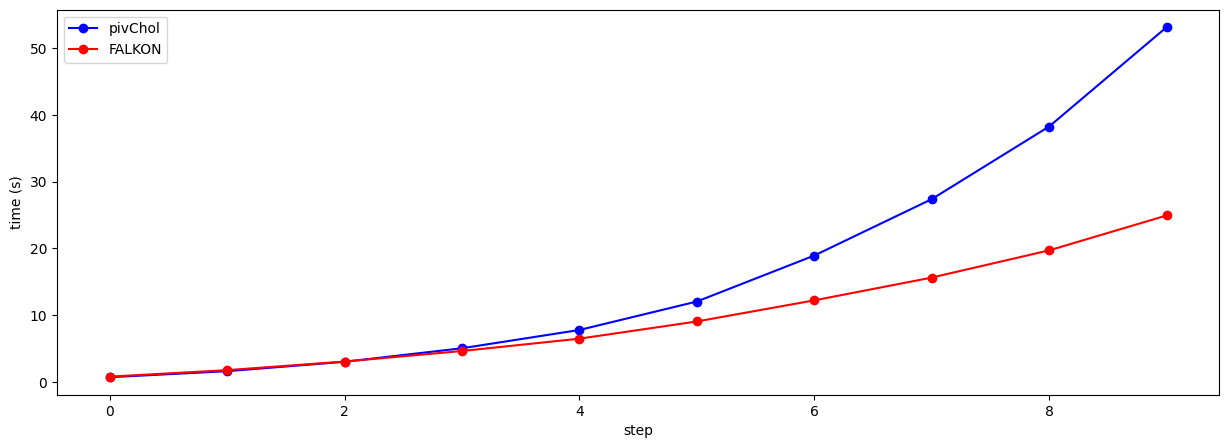

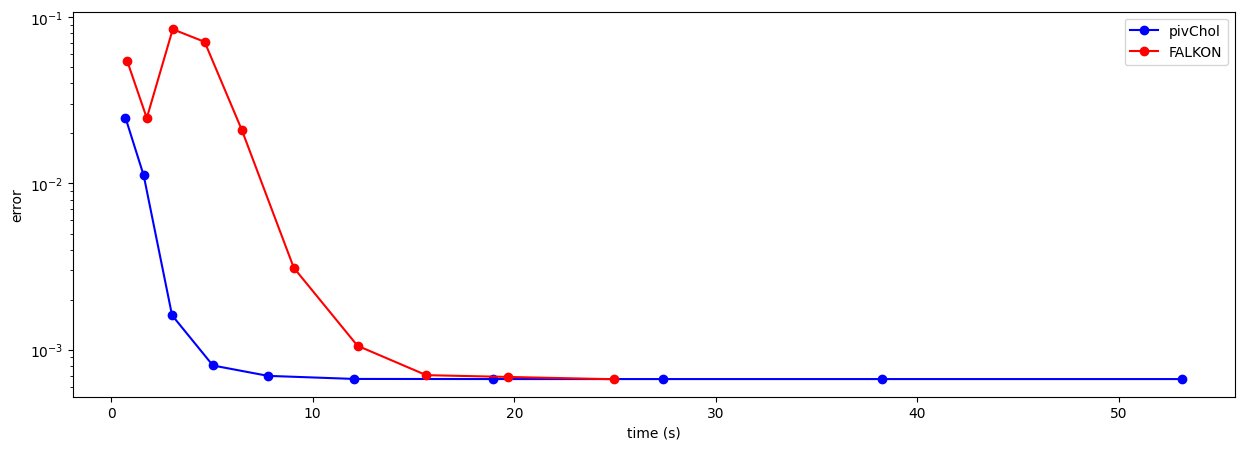

In [5]:
plt.figure(figsize=(15,5))
plt.plot(range(10), tchol, 'bo-', label='pivChol')
plt.plot(range(10), tfalkon, 'ro-', label='FALKON')
plt.xlabel("step")
plt.ylabel("time (s)")
plt.legend()
plt.show()
plt.figure(figsize=(15,5))
plt.semilogy(tchol,errchol, 'bo-', label='pivChol')
plt.semilogy(tfalkon, errfalkon, 'ro-', label='FALKON')
plt.xlabel("time (s)")
plt.ylabel("error")
plt.legend()
plt.show()

## Kernel mean embedding

As a hypothesis space, we consider a tensor product RKHS 
$\mathcal{H}=\mathcal{H}_X \otimes \mathcal{H}_Y$ to
estimate, for any $x\in \mathcal{X}$, the conditional expectation operator 
$\mu _{Y|X=x}\in \mathcal{H}_Y$ acting as a linear functional on $\mathcal{H}_Y$, i.e.,
$$
 \langle f,\mu _{Y|X=x} \rangle _{\mathcal{H}_{Y}}=\int_{\mathcal{Y}} f\mathrm{d}\mathbb 
 P_{Y|X=x},\quad\text{for all $f\in \mathcal{H}_Y$.}
$$
We make a tensor product ansatz, which yields
$$
  \boldsymbol F=(\boldsymbol K_X+n\lambda \boldsymbol I_n)^{-1}, \, \text{ and  } 
  \hat{\mu} _{Y|X=\cdot}= {\boldsymbol\Phi}_Y(\cdot)(\boldsymbol K_X
  +n\lambda \boldsymbol I_n)^{-1} {\boldsymbol\Phi}_X(\cdot)^T.
$$
This estimator of the conditional expectation operator results in
$$
 \langle f,\hat{\mu}_{Y|X=x} \rangle _{\mathcal{H}_{Y}}=[f(y_1),\dots,f(y_n)] 
 \boldsymbol F {\boldsymbol\Phi}_X^T(x)\quad\text{for all $f\in \mathcal{H}_Y$.}
 $$
Using low-rank approximations of the involved kernels, we arrive at
$$
      \boldsymbol F\approx \boldsymbol B_{Y} \boldsymbol V _Y 
      \tilde { \boldsymbol F} \boldsymbol V _X^T \boldsymbol B_{X}^{T}
$$
with
$$
\tilde{\boldsymbol F}^{T}=(\boldsymbol\Lambda _X+n\lambda \boldsymbol I_{m_X})^{-1}
\boldsymbol V_X^{T}\boldsymbol L_X^{T}\boldsymbol L_Y\boldsymbol V_Y,
$$